In [28]:
## imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split


In [29]:
out = np.load('disc-benchmark-files/training-val-test-data.npz')
th_train = out['th']
u_train = out['u']


In [30]:
def create_IO_data(u,y,na,nb):
    X = []
    Y = []
    for k in range(max(na,nb), len(y)):
        X.append(np.concatenate([u[k-nb:k],y[k-na:k]]))
        Y.append(y[k])
    return np.array(X), np.array(Y)

In [31]:
nu = 15
nth = 15
Xtrain, Ytrain = create_IO_data(u_train, th_train, nu, nth)

In [32]:

## Model
class SimpleANN(nn.Module):
    def __init__(self,nu, ny):
        super(SimpleANN,self).__init__()
        self.n_hidden_nodes1 =128
        self.n_hidden_nodes2 = 64
        self.n_hidden_nodes3 = 16
        #self.lay1 = nn.Linear(nu+ny,self.n_hidden_nodes1).double()
        #self.lay2 = nn.Linear(self.n_hidden_nodes1,self.n_hidden_nodes2).double()
        #self.lay3 = nn.Linear(self.n_hidden_nodes2,self.n_hidden_nodes3).double()
        #self.lay4 = nn.Linear(self.n_hidden_nodes3,1).double()
        self.lay1 = nn.Linear(nu+ny,self.n_hidden_nodes1).double()

        self.lay4 = nn.Linear(self.n_hidden_nodes1,1).double()
    def forward(self, x):
        x1 = torch.relu(self.lay1(x))
        #x2 = torch.relu(self.lay2(x1))
        #x3 = torch.relu(self.lay3(x2))
        y = self.lay4(x1)[:,0]
        return y

In [33]:

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain) 

In [34]:

epochs = 10000 
model = SimpleANN(nu, nth)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
Xtrain = torch.as_tensor(Xtrain)
Ytrain = torch.as_tensor(Ytrain)
Xval = torch.as_tensor(Xval)
Yval = torch.as_tensor(Yval)
Loss_save = []
Loss_val_save = []
for epoch in range(epochs):
    Loss = torch.mean((model(Xtrain)-Ytrain)**2)
    optimizer.zero_grad()
    Loss.backward()
    optimizer.step()
    if epoch%100==0:
        with torch.no_grad():
            Loss_val = torch.mean((model(Xval) - Yval)**2)**0.5
            Loss_train = torch.mean((model(Xtrain) - Ytrain)**2)**0.5
            Loss_save.append(Loss_train.item())
            Loss_val_save.append(Loss_val.item())
            print(f'epoch={epoch}, Validation Loss (RMSE)={Loss_val.item():}, Train Loss (RMSE)={Loss_train.item():}')
    if epoch == epochs-1:
        with torch.no_grad():
            Loss_val = torch.mean((model(Xval) - Yval)**2)**0.5
            Loss_train = torch.mean((model(Xtrain) - Ytrain)**2)**0.5
            Loss_save.append(Loss_train.item())
            Loss_val_save.append(Loss_val.item())
            print(f'Final: epoch={epoch}, Validation Loss (RMSE)={Loss_val.item():}, Train Loss (RMSE)={Loss_train.item():}')

epoch=0, Validation Loss (RMSE)=0.4364874487747069, Train Loss (RMSE)=0.4342201729245813
epoch=100, Validation Loss (RMSE)=0.056035781063502814, Train Loss (RMSE)=0.05452959135713204
epoch=200, Validation Loss (RMSE)=0.03962184329446799, Train Loss (RMSE)=0.0380461255170777
epoch=300, Validation Loss (RMSE)=0.03057711737099038, Train Loss (RMSE)=0.02909509670047645
epoch=400, Validation Loss (RMSE)=0.02530180591295901, Train Loss (RMSE)=0.023935789828050898
epoch=500, Validation Loss (RMSE)=0.021392351059518883, Train Loss (RMSE)=0.020086890913880807
epoch=600, Validation Loss (RMSE)=0.01851244995931952, Train Loss (RMSE)=0.017339326080212686
epoch=700, Validation Loss (RMSE)=0.016344508193308797, Train Loss (RMSE)=0.01526279145816467
epoch=800, Validation Loss (RMSE)=0.01460992549418751, Train Loss (RMSE)=0.013579410391841736
epoch=900, Validation Loss (RMSE)=0.013205567815980567, Train Loss (RMSE)=0.012246353202475442
epoch=1000, Validation Loss (RMSE)=0.012144182360606066, Train Los

In [35]:
print(Loss**0.5)

tensor(0.0031, dtype=torch.float64, grad_fn=<PowBackward0>)


In [36]:
print(Loss_val_save[-1])
print(Loss_save[-1])

0.0034055705721660716
0.003067980944835015


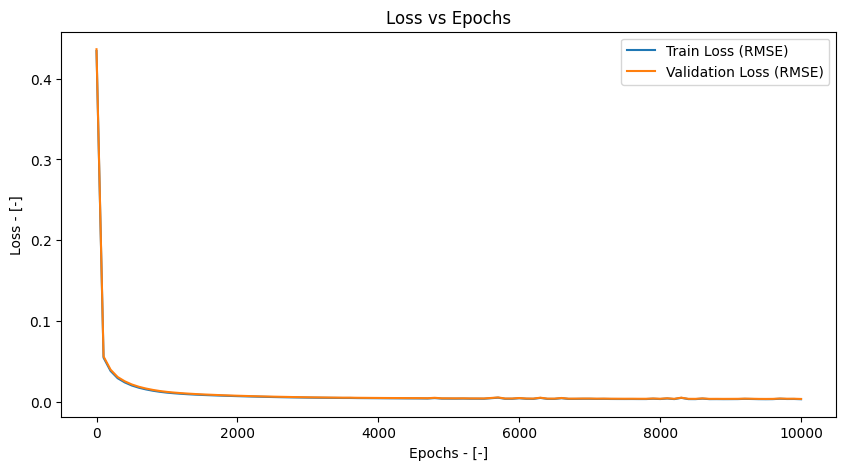

In [37]:
## Plotting the loss
x = np.arange(0, len(Loss_save))*100
plt.figure(figsize=(10,5))
plt.plot(x,Loss_save, label='Train Loss (RMSE)')
plt.plot(x,Loss_val_save, label='Validation Loss (RMSE)')
plt.xlabel('Epochs - [-]')
plt.ylabel('Loss - [-]')
plt.title('Loss vs Epochs')
plt.legend()

In [38]:
Ytrain_pred = model(Xtrain)

In [39]:
print(Xval.shape)
Yval_pred = model(Xval)

torch.Size([8747, 30])


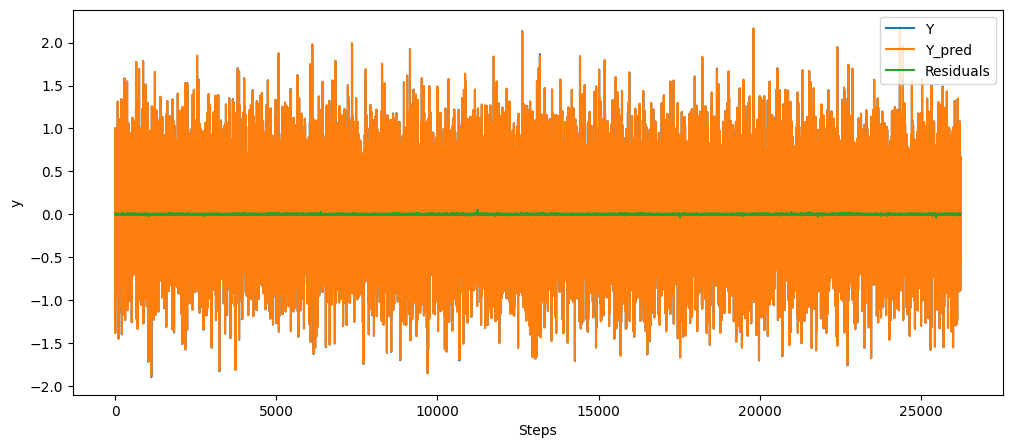

In [40]:


plt.figure(figsize=(12,5))
plt.plot(Ytrain.detach().numpy())
plt.plot(Ytrain_pred.detach().numpy())
plt.plot((Ytrain.detach() - Ytrain_pred.detach()).numpy())
plt.xlabel('Steps') 
plt.ylabel('y') 
plt.legend(['Y','Y_pred','Residuals'])
plt.show()



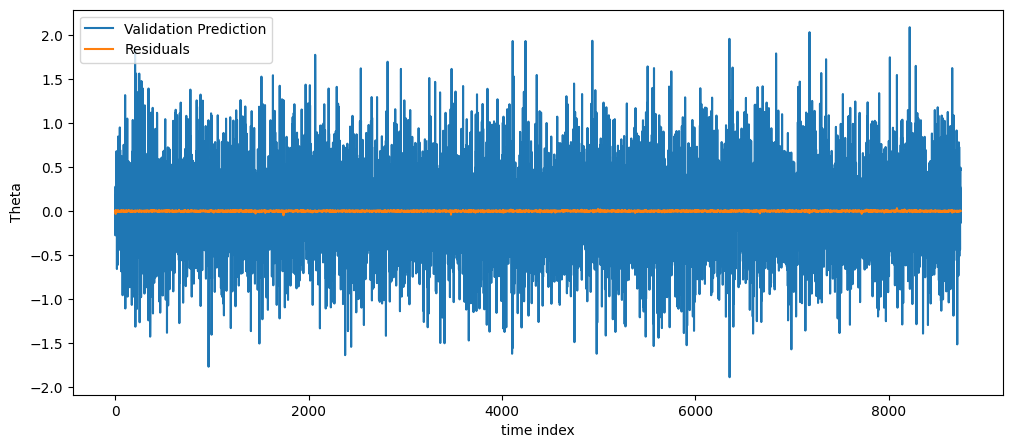

RMS prediction 0.0034055705721660716


In [41]:
res = Yval_pred - Yval
plt.figure(figsize=(12,5))
plt.plot(Yval.detach().numpy())
plt.plot(res.detach().numpy())
plt.xlabel('time index') 
plt.ylabel('Theta') 
plt.legend(['Validation Prediction','Residuals'])
plt.show()
print('RMS prediction',np.mean((res.detach().numpy()**2))**0.5)

In [42]:
## Getting the testing files stuff
data = np.load('disc-benchmark-files/hidden-test-prediction-submission-file.npz')
utest_pred = data['upast']
thtest_pred = data['thpast']

data2 = np.load('disc-benchmark-files/hidden-test-simulation-submission-file.npz')
utest_sim = data2['u']
thtest_sim = data2['th']


In [51]:
## Prediction
print(thtest_pred[0,:].shape)
print(utest_pred[0,:].shape)
dataset = np.concatenate((utest_pred,thtest_pred),axis = 1)
tensor_dataset = torch.tensor(dataset)
Thout = model(tensor_dataset)
print(tensor_dataset.shape)
print(Thout.shape)
Th_out_np = np.expand_dims(Thout.detach().numpy(),1)
print(Th_out_np.shape)
np.savez('submissions/simple_pred.npz',upast =utest_pred,thpast=thtest_pred,thnow = Th_out_np)

(15,)
(15,)
torch.Size([645, 30])
torch.Size([645])
(645, 1)


In [45]:
## Simulation
thsim = thtest_sim.copy() 
th_in = thsim[:nth]

for u in range(max(nu,nth),utest_sim[nu:].shape[0]):
    inp = np.concatenate((utest_sim[u-nu:u],th_in)) 
    y = model(torch.tensor(inp[:,None].T)).detach().numpy() 
    
    th_in = th_in.tolist()
    th_in.append(y[0])
    th_in.pop(0)
    th_in = np.array(th_in)
    thsim[u] = y[0] # save output
np.savez('submissions/simple_sim.npz',u =utest_sim,th=thsim)

In [46]:
## Simulation stuff.
## Update
th_temp = th_train.copy()
th_temp[nth:] = 0
th_in = th_temp[:nth]

for u in range(max(nu,nth),u_train[nu:].shape[0]):
    inp = np.concatenate((u_train[u-nu:u],th_in)) 
    y = model(torch.tensor(inp[:,None].T)).detach().numpy() 
    th_in = th_in.tolist()
    th_in.append(y[0])
    th_in.pop(0)
    th_in = np.array(th_in)
    th_temp[u] = y[0] 



res = th_temp - th_train

print('RMS:', np.mean((res)**2)**0.5)

RMS: 0.015250764240052082


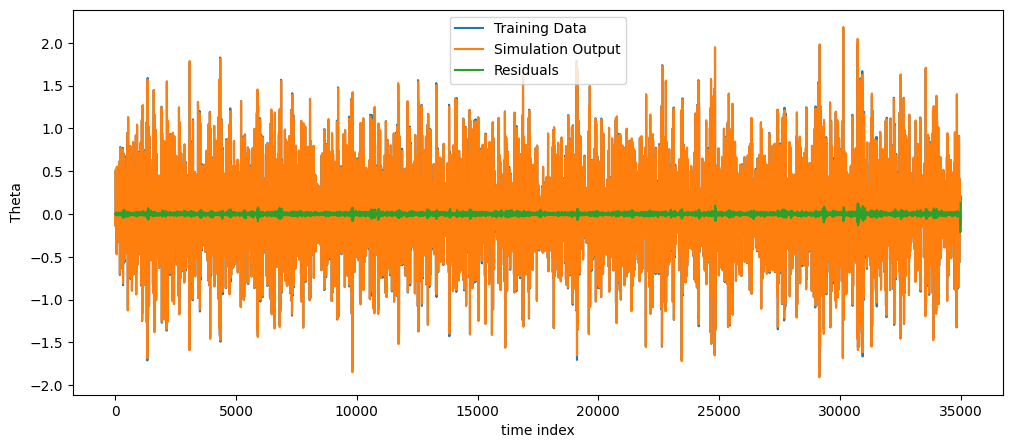

In [47]:
#PLotting Simulation
plt.figure(figsize=(12,5))
plt.plot(th_train, label='Training Data')
plt.plot(th_temp, label='Simulation Output')
plt.plot(res, label='Residuals')
plt.xlabel('time index')
plt.ylabel('Theta')
plt.legend()
plt.show()

(645, 1)
(645, 1)
(645, 1)
RMSE between advanced and simple prediction: 0.003338036287370637


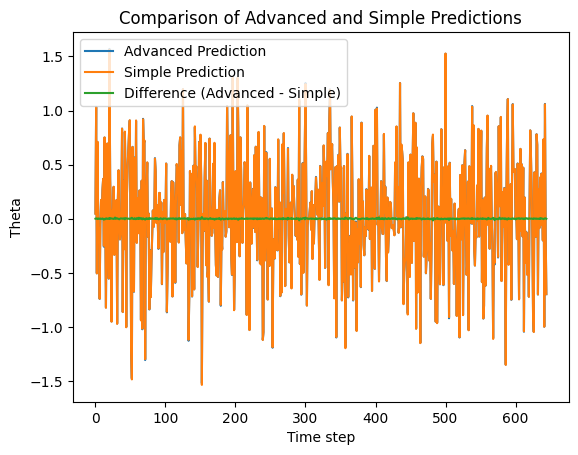

In [56]:
data = np.load('submissions/advanced_pred.npz')
data1 = np.load('submissions/simple_pred.npz')
uadv = data['thnow']
usim = data1['thnow']
print(uadv.shape)
print(usim.shape)

rmse = np.mean((uadv-usim)**2)**0.5
print((uadv-usim).shape)
print(f'RMSE between advanced and simple prediction: {rmse}')
plt.plot(uadv, label='Advanced Prediction')
plt.plot(usim, label='Simple Prediction')

plt.plot(uadv-usim, label='Difference (Advanced - Simple)')
plt.xlabel('Time step')
plt.ylabel('Theta')
plt.title('Comparison of Advanced and Simple Predictions')
plt.legend()    
plt.show()